# Лабораторная работа №4: "Поиск пути в среде с преградами"
---

## Дано

Клеточное поле размером $m \times n$. Шаг между соседними клетками равен 1.

Поле заполнено заданным числом препятствий, расположенных случайным образом.
Каждое препятствие имеет единичную ширину и случайную длину в диапазоне длин от $l_{min}$ до $l_{max}$, выбираемую из равномерного распределения. Ориентация (горизонтальная или вертикальная) преграды на поле выбирается также случайным образом.

В районе левой части поля случайным образом выбирается свободная клетка. Обозначается как точка ${\bf P}_0$. В правой части аналогичным образом определяется точка ${\bf P}_1$.
* Размеры левой области (появления точки ${\bf P}_0$) принять следующими:
  $x_{min}^{left} = 0$, $x_{max}^{left} = \left\lfloor n/5 \right\rfloor$,
  $y_{min}^{left} = 0$, $y_{max}^{left} = m$.
* Размеры правой области (генерирования точки ${\bf P}_1$):
  $x_{min}^{right} = n - \left\lfloor n/5 \right\rfloor$, $x_{max}^{right} = n$,
  $y_{min}^{right} = 0$, $y_{max}^{right} = m$.

**Замечания:**

* Из каждой клетки возможны 4 перемещения: вверх, вправо, вниз, влево.

## Требуется

1. Найти кратчайший путь из точки ${\bf P}_0$ в точку ${\bf P}_1$, используя алгоритм эвристического поиска A*.
2. Показать решение графически.

## Ход работы
---

### Подключение необходимых библиотек

In [43]:
%matplotlib inline

from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt
import numpy as np
import heapq

### Инициализация генератора случайных чисел

Необходим для воспроизведения и сравнения результатов. Если `seed != None`, а есть любое неотрицательное число, то при каждом запуске программы генератор будет выдавать одну и ту же последовательность чисел.

In [44]:
seed = None
rs = Generator(PCG64(seed))

### Класс очереди (соседей)

In [45]:
class PriorityQueue(object):
    """
    Класс Очереди с приоритетами
    Кладем в кучу элемент и его приоритет, вытаскиваем элемент с наименьшим приоритетом:
    Берем соседа данной вершины с наименьшей стоимостью
    """
    def __init__(self):
        self.elements = []
    
    def is_empty(self):
        return len(self.elements) == 0
    
    def put(self, elem, priority):
        heapq.heappush(self.elements, (priority, elem))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

### Класс графа (сетки)

In [46]:
class Grid(object):
    
    def __init__(self, size: tuple, n_obs: int, obs_len: tuple):
        self.grid = np.ones(shape=size, dtype=int)
        self.fill_obstacles(n_obs, obs_len)
        self.weights = dict()
    
    def fill_obstacles(self, n, obs_len):
        """
        Заполнить клеточное поле `grid` `n` препятствиями.
        Препятствие имеет случайную длину в диапазоне от `min_len` до `max_len`.
        """
        for i in range(n):
        
            x, y = np.random.randint([0, 0], [self.grid.shape[0], self.grid.shape[1]])
            obs = [x], [y]
            len_obs = np.random.randint(obs_len[0], obs_len[1])
            step = np.random.randint(1, 5)
        
            k = 0
            while k < len_obs:
            
                # 1 - up, 2 - right, 3 - down, 4 - left
                if step == 1:
                    y -= 1
                elif step == 2:
                    x += 1
                elif step == 3:
                    y += 1
                elif step == 4:
                    x -= 1
            
                if 0 <= x < self.grid.shape[0] and 0 <= y < self.grid.shape[1]:
                    obs[0].append(x)
                    obs[1].append(y)
            
                k += 1
        
            self.grid[obs[0], obs[1]] = 0
    
    def in_bounds(self, id):
        return 0 <= id[0] < self.grid.shape[0] and 0 <= id[1] < self.grid.shape[1]
    
    def is_not_obstacle(self, id):
        return self.grid[id] == 1
    
    def get_neighbors(self, id):
        x, y = id
        neighbors = [(x+1, y), (x, y-1), (x-1, y), (x, y+1)]
        neighbors = filter(self.in_bounds, neighbors)
        neighbors = filter(self.is_not_obstacle, neighbors)
        return neighbors
    
    def cost(self, node2):
        return self.weights.get(node2, 1)

### Алгоритм А*

In [47]:
def search_short_path(graph, start_node, end_node, w=1):
    
    """
    Алгоритм А*
    """
    
    heuristic = lambda node1, node2: abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])
    
    frontier = PriorityQueue()
    frontier.put(start_node, 0)
    
    path = {start_node: None}
    cost = {start_node: 0}
    
    while not frontier.is_empty():
        
        current_node = frontier.get()
        
        if current_node == end_node:
            break
        
        for next_node in graph.get_neighbors(current_node):
            
            new_cost = cost[current_node] + graph.cost(next_node)
            
            if (next_node not in cost) or (new_cost < cost[next_node]):
                cost[next_node] = new_cost
                priority = new_cost + w * heuristic(end_node, next_node)
                frontier.put(next_node, priority)
                path[next_node] = current_node
    
    return path, cost

### Функция генерации точки в свободной ячейке в заданной области

In [48]:
def gen_point_in_area(grid, xlim, ylim):
    """
    Сгенерировать случайную точку в заданной области поля `grid`.
    Параметры `xlim` и `ylim` определяют размеры и положение области генерации точки.
    """
    x, y = tuple(np.random.randint([xlim[0], ylim[0]], [xlim[1], ylim[1]]))
    while grid.grid[(x,y)] == 0:
        x, y = tuple(np.random.randint([xlim[0], ylim[0]], [xlim[1], ylim[1]]))
    return x, y

### Инициилизация исходных данных

In [80]:
size = 100, 100
n_obs = 250
len_obs = 1, 7
xlim0, ylim0 = [0, size[1] // 5], [0, size[0]]
xlim1, ylim1 = [size[1] - size[1] // 5, size[1]], [0, size[0]]

### Создание графа (сетки) и инициилизация точек старта и цели

In [81]:
GRID = Grid(size, n_obs, len_obs)

In [82]:
GRID.grid

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [83]:
P0 = gen_point_in_area(GRID, xlim0, ylim0)
P1 = gen_point_in_area(GRID, xlim1, ylim1)

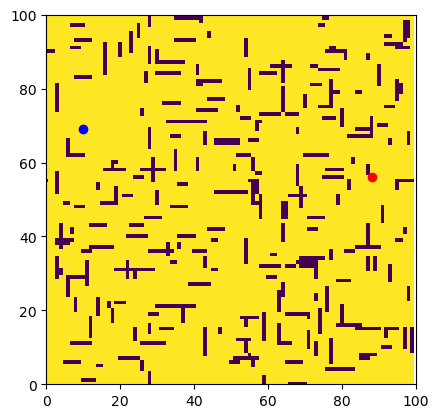

In [84]:
plt.imshow(GRID.grid)
plt.scatter(*P0, color='b')
plt.scatter(*P1, color='r')
plt.xlim(0,size[1]), plt.ylim(0,size[0])
plt.show()

### Моделирование

In [85]:
path, cost_so_far = search_short_path(GRID, P0, P1)

### Визуализация

In [92]:
def plot_grid(grid, path, P0, P1, w=1,
              cmap_grid='Dark2', cmap_traj='brg',
              draw=True):
    
    """
    Визуализировать клеточное поле `grid`
    """
    
    def image_trajectory(grid, came_from, goal):
        image = np.full(grid.grid.shape, np.nan)
        traj = [goal]
        while not (traj[-1] is None):
            traj.append(came_from[traj[-1]])
        traj.pop()
        for point in traj:
            image[point] = 1
        return image, len(traj)
    
    image_traj, len_traj = image_trajectory(grid, path, P1)
    
    print(f'Длина пути = {len_traj} при w = {w}')
    
    if draw:
        plt.title(f'Длина пути = {len_traj} при w={w}')
        plt.imshow(grid.grid, cmap=cmap_grid)
        plt.imshow(image_traj.T, cmap=cmap_traj)
        plt.scatter(*P0, color='darkorange', edgecolor='k')
        plt.scatter(*P1, color='r', edgecolor='k')
        plt.xlim(0,size[0]), plt.ylim(0,size[1])
        plt.show()
    
    return image_traj, len_traj

Длина пути = 94 при w = 1


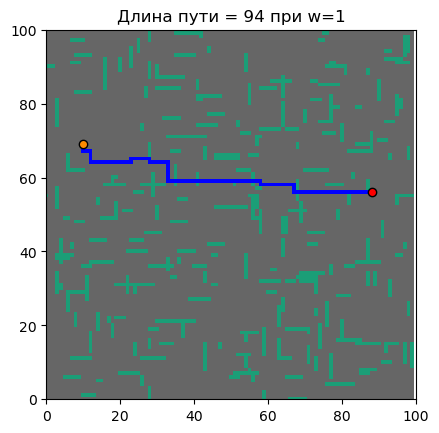

In [93]:
image_trajectory, len_traj = plot_grid(GRID, path, P0, P1)

### Варьируем вес эвристической функции

In [106]:
W = np.arange(0.1,2.2,0.1)

In [107]:
L = []
IM = []
for w in W:
    path, cost_so_far = search_short_path(GRID, P0, P1, w)
    image_trajectory, len_traj = plot_grid(GRID, path, P0, P1, w, draw=False)
    IM.append(image_trajectory)
    L.append(len_traj)

Длина пути = 94 при w = 0.1
Длина пути = 94 при w = 0.2
Длина пути = 94 при w = 0.30000000000000004
Длина пути = 94 при w = 0.4
Длина пути = 94 при w = 0.5
Длина пути = 94 при w = 0.6
Длина пути = 94 при w = 0.7000000000000001
Длина пути = 94 при w = 0.8
Длина пути = 94 при w = 0.9
Длина пути = 94 при w = 1.0
Длина пути = 96 при w = 1.1
Длина пути = 96 при w = 1.2000000000000002
Длина пути = 102 при w = 1.3000000000000003
Длина пути = 104 при w = 1.4000000000000001
Длина пути = 104 при w = 1.5000000000000002
Длина пути = 104 при w = 1.6
Длина пути = 104 при w = 1.7000000000000002
Длина пути = 106 при w = 1.8000000000000003
Длина пути = 106 при w = 1.9000000000000001
Длина пути = 106 при w = 2.0
Длина пути = 106 при w = 2.1


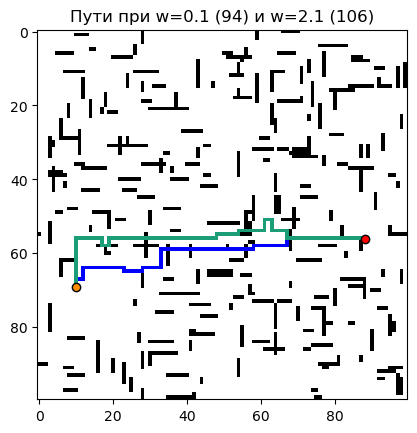

In [131]:
plt.title(f'Пути при w={W[0]} (94) и w={W[-1]} (106)')
plt.imshow(GRID.grid, cmap='bone')
plt.imshow(IM[0].T, cmap='brg')
plt.imshow(IM[-1].T, cmap='Dark2')
plt.scatter(*P0, color='darkorange', edgecolor='k')
plt.scatter(*P1, color='r', edgecolor='k')
plt.show()

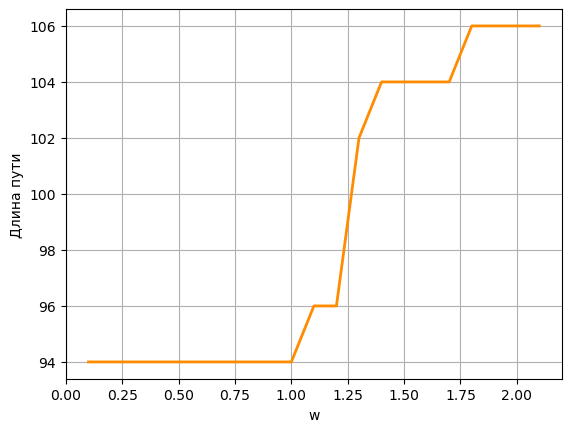

In [105]:
plt.plot(W, L, color='darkorange', lw=2)
plt.xlabel('w'), plt.ylabel('Длина пути')
plt.grid()
plt.show()